In [1]:
import tensorflow as tf
def Init_TPU():  

    try:
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(resolver)
        tf.tpu.experimental.initialize_tpu_system(resolver)
        strategy = tf.distribute.experimental.TPUStrategy(resolver)
        REPLICAS = strategy.num_replicas_in_sync
        print("Connected to TPU Successfully:\n TPUs Initialised with Replicas:",REPLICAS)
        
        return strategy
    
    except ValueError:
        
        print("Connection to TPU Falied")
        print("Using default strategy for CPU and single GPU")
        strategy = tf.distribute.get_strategy()
        
        return strategy
    
strategy=Init_TPU()

2022-12-06 04:48:31.201143: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-12-06 04:48:31.201259: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-06 04:48:36.411829: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-06 04:48:36.414870: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-12-06 04:48:36.414916: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-06 04:48:36.414938: I tensorflow/stream_executor/cuda/cud

Connected to TPU Successfully:
 TPUs Initialised with Replicas: 8


In [2]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:import pandas as pd
#         import numpy as np
#         print(os.path.join(dirname, filename))

In [3]:
import pandas as pd
import numpy as np

In [4]:
train=pd.read_csv("/kaggle/input/contradictory-my-dear-watson/train.csv")
test=pd.read_csv("/kaggle/input/contradictory-my-dear-watson/test.csv")

<AxesSubplot:title={'center':'Number of instances in each label in Training Data'}, xlabel='label', ylabel='count'>

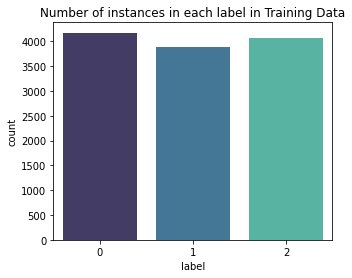

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5,4))
plt.title("Number of instances in each label in Training Data")
sns.countplot(x=train['label'],palette="mako")

<AxesSubplot:title={'center':'Number of instances in each language-Training Data'}, xlabel='language', ylabel='count'>

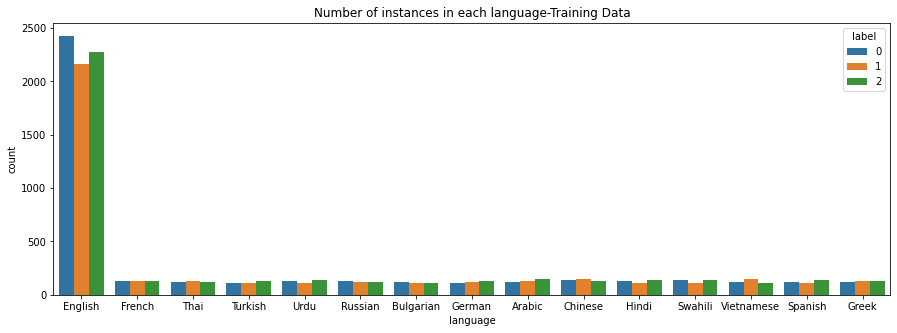

In [6]:
plt.figure(figsize=(15,5))
plt.title("Number of instances in each language-Training Data")
sns.countplot(x=train['language'],hue=train['label'])

<AxesSubplot:title={'center':'Number of instances in each language-Testing Data'}, xlabel='language', ylabel='count'>

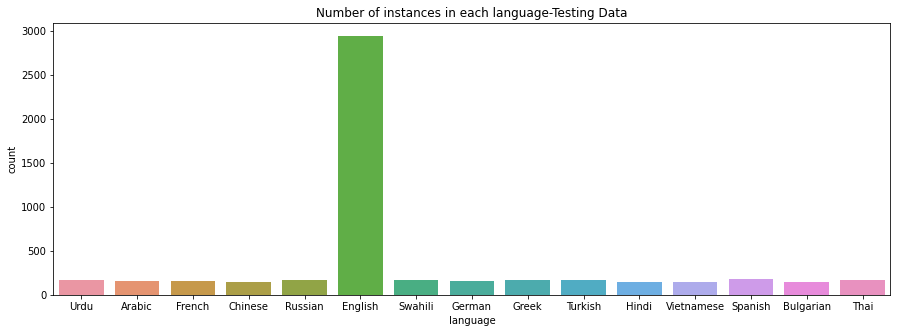

In [7]:
plt.figure(figsize=(15,5))
plt.title("Number of instances in each language-Testing Data")
sns.countplot(x=test['language'])

In [8]:
import re
import html
import unicodedata
import string
def to_lowercase(text):
    return text.lower()
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)
def remove_whitespaces(text):
    return text.strip()
def remove_special_chars(text):
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x1))

In [9]:
def cleaned_text( text):
    text = remove_special_chars(text)
    text = remove_punctuation(text)
    text = to_lowercase(text)
    text = remove_whitespaces(text)
    return ''.join(text)

In [10]:
train['premise'] = train['premise'].apply(lambda x: cleaned_text(x))
train['hypothesis'] = train['hypothesis'].apply(lambda x: cleaned_text(x))
test['premise'] = test['premise'].apply(lambda x: cleaned_text(x))
test['hypothesis'] = test['hypothesis'].apply(lambda x: cleaned_text(x))

In [11]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Adamax
from transformers import DistilBertTokenizer, TFDistilBertModel    
from sklearn.model_selection import train_test_split
from tabulate import tabulate

In [12]:
distilbert = 'distilbert-base-multilingual-cased'

In [13]:
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(distilbert)

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [14]:
sentence = 'Amazing, My Dear Watson!'
print("DistilBERT Model Tokenizer Output:",distilbert_tokenizer.convert_tokens_to_ids(list(distilbert_tokenizer.tokenize(sentence))))

DistilBERT Model Tokenizer Output: [48060, 117, 11590, 51555, 19229, 106]


In [15]:
train_data = train[['premise','hypothesis']].values.tolist()
test_data = test[['premise','hypothesis']].values.tolist()

In [16]:
max_len = 20  

train_data_encode = distilbert_tokenizer.batch_encode_plus(train_data, pad_to_max_length=True, max_length=max_len)
test_data_encode = distilbert_tokenizer.batch_encode_plus(test_data, pad_to_max_length=True, max_length=max_len)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [17]:
X_train, X_val, y_train, y_val = train_test_split(train_data_encode['input_ids'], train.label.values, test_size=0.1)

X_test = test_data_encode['input_ids']

In [18]:
AUTO = tf.data.experimental.AUTOTUNE
batch_size = 16 * strategy.num_replicas_in_sync

train_dataset = (tf.data.Dataset.from_tensor_slices((X_train, y_train)).repeat().shuffle(3072).batch(batch_size).prefetch(AUTO))
val_dataset = (tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(AUTO))

test_dataset = (tf.data.Dataset.from_tensor_slices(X_test).batch(batch_size))

In [19]:
def build_model(strategy,transformer):
    with strategy.scope():
        transformer_encoder = TFDistilBertModel.from_pretrained(transformer)  #Pretrained BERT Transformer Model
        
        input_layer = Input(shape=(max_len,), dtype=tf.int32, name="input_layer")
        
        sequence_output = transformer_encoder(input_layer)[0]
        
        class_token = sequence_output[:, 0, :]
        
        output_layer = Dense(3, activation='softmax')(class_token)
        
        model = Model(inputs=input_layer, outputs=output_layer)
        
        model.compile(
            Adamax(lr=1e-6), 
            loss='sparse_categorical_crossentropy', 
            metrics=['accuracy']
        )
        
        return model

In [20]:
model = build_model(strategy,distilbert)

Downloading:   0%|          | 0.00/466 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/911M [00:00<?, ?B/s]

2022-12-06 04:49:34.462005: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
Some layers from the model checkpoint at distilbert-base-multilingual-cased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-multilingual-cased.
If your task is similar to the 

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 20)]              0         
_________________________________________________________________
tf_distil_bert_model (TFDist TFBaseModelOutput(last_hi 134734080 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 2307      
Total params: 134,736,387
Trainable params: 134,736,387
Non-trainable params: 0
_________________________________________________________________


In [22]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=4,restore_best_weights=True)

In [23]:
epochs = 50
n_steps = len(train_data) // batch_size 

history=model.fit(train_dataset, 
          steps_per_epoch = n_steps, 
          validation_data = val_dataset,
          callbacks=[early_stop],epochs = epochs,verbose=1)

Epoch 1/50
94/94 [==============================] - 49s 127ms/step - loss: 1.1532 - accuracy: 0.3163 - val_loss: 1.1142 - val_accuracy: 0.3168
Epoch 2/50
94/94 [==============================] - 5s 55ms/step - loss: 1.1248 - accuracy: 0.3211 - val_loss: 1.1100 - val_accuracy: 0.3284
Epoch 3/50
94/94 [==============================] - 5s 54ms/step - loss: 1.1174 - accuracy: 0.3358 - val_loss: 1.1072 - val_accuracy: 0.3309
Epoch 4/50
94/94 [==============================] - 5s 54ms/step - loss: 1.1137 - accuracy: 0.3358 - val_loss: 1.1045 - val_accuracy: 0.3358
Epoch 5/50
94/94 [==============================] - 5s 55ms/step - loss: 1.1116 - accuracy: 0.3471 - val_loss: 1.1028 - val_accuracy: 0.3416
Epoch 6/50
94/94 [==============================] - 5s 54ms/step - loss: 1.1125 - accuracy: 0.3352 - val_loss: 1.1020 - val_accuracy: 0.3432
Epoch 7/50
94/94 [==============================] - 5s 56ms/step - loss: 1.1093 - accuracy: 0.3430 - val_loss: 1.1006 - val_accuracy: 0.3507
Epoch 8/50


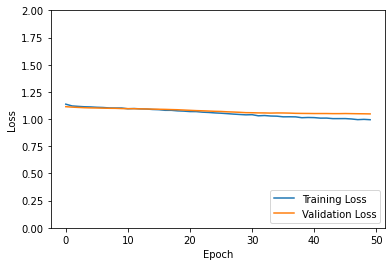

In [24]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='lower right')

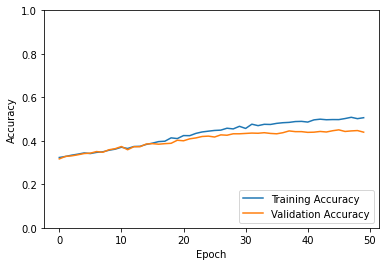

In [25]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [26]:
results=model.predict(test_dataset,verbose=1)

41/41 [==============================] - 7s 121ms/step


In [27]:
predicted_class=results.argmax(axis=1)

In [28]:
submission=pd.DataFrame()
submission['id']=test['id']
submission['prediction']=predicted_class

In [29]:
submission.head()

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,1
2,e98005252c,1
3,58518c10ba,0
4,c32b0d16df,2


In [30]:
submission.to_csv("submission.csv",index=False)